In [1]:
import json
from collections import Counter, defaultdict
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Function to load JSON data from a file
def load_json(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data
# Function to extract and count polarities and categories
def count_labels(data):
    polarity_counter = Counter()
    category_counter = Counter()

    for entry in data:
        for label in entry.get('labels', []):
            if len(label) >= 2:
                category, polarity = label[0], label[1]
                category_counter[category] += 1
                polarity_counter[polarity] += 1

    return category_counter, polarity_counter

# Wrapper function to load and process a dataset
def process_dataset(filepath):
    data = load_json(filepath)
    category_counts, polarity_counts = count_labels(data)
    length_info = analyze_text_lengths(data)

    return category_counts, polarity_counts, length_info


# Function to analyze text lengths

def analyze_text_lengths(data):
    lengths = [len(entry['text']) for entry in data]
    avg_length = sum(lengths) / len(lengths) if lengths else 0
    median_length = np.median(lengths) if lengths else 0

    # Find longest and shortest
    max_len = max(lengths) if lengths else 0
    min_len = min(lengths) if lengths else 0

    longest = next(entry for entry in data if len(entry['text']) == max_len)
    shortest = next(entry for entry in data if len(entry['text']) == min_len)

    return {
        'average_length': avg_length,
        'median_length': median_length,
        'longest_text': longest,
        'shortest_text': shortest
    }

# Main logic to process both datasets
def analyze_datasets(data_dir):
    train_path = os.path.join(data_dir, 'train.json')
    test_path = os.path.join(data_dir, 'test.json')

    train_category, train_polarity, train_lengths = process_dataset(train_path)
    test_category, test_polarity, test_lengths = process_dataset(test_path)

    return {
        'train': {
            'categories': train_category,
            'polarities': train_polarity,
            'length_info': train_lengths
        },
        'test': {
            'categories': test_category,
            'polarities': test_polarity,
            'length_info': test_lengths
        }
    }

def counter_to_df(counter, label_name='Label'):
    return pd.DataFrame({
        label_name: list(counter.keys()),
        'Count': list(counter.values())
    })

def plot_counts(df, title, x_label='Label'):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x='Count',
        y=df.columns[0],
        data=df,
        hue=df.columns[0],  # Assign y variable to hue
        palette='pastel',
        legend=False         # Disable legend since it's redundant
    )
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(x_label)
    plt.tight_layout()
    plt.show()

def prepare_comparison_df(train_counter, test_counter, label_name='Label'):
    # Get all unique labels
    all_labels = set(train_counter) | set(test_counter)

    # Build a DataFrame
    data = []
    for label in all_labels:
        data.append({
            label_name: label,
            'Count': train_counter.get(label, 0),
            'Dataset': 'Train'
        })
        data.append({
            label_name: label,
            'Count': test_counter.get(label, 0),
            'Dataset': 'Test'
        })

    return pd.DataFrame(data)

def plot_comparison(df, label_col='Label', title='Comparison'):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Count',
        y=label_col,
        hue='Dataset',
        data=df,
        palette='pastel'
    )
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=-25)
    
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(label_col)
    plt.tight_layout()
    plt.show()




In [3]:
results = analyze_datasets('../../04_data/datasets/gerestaurant/')

print("Train - Categories:", results['train']['categories'])
print("Train - Polarities:", results['train']['polarities'])

print("Test - Categories:", results['test']['categories'])
print("Test - Polarities:", results['test']['polarities'])

Train - Categories: Counter({'food': 1202, 'service': 766, 'general impression': 540, 'ambience': 355, 'price': 176})
Train - Polarities: Counter({'positive': 1667, 'negative': 1256, 'neutral': 116})
Test - Categories: Counter({'food': 510, 'service': 320, 'general impression': 236, 'ambience': 130, 'price': 79})
Test - Polarities: Counter({'positive': 672, 'negative': 539, 'neutral': 64})


In [9]:
print(sum(results['train']['polarities'].values()), "train polarities")
print(sum(results['test']['polarities'].values()), "test polarities")

3039 train polarities
1275 test polarities


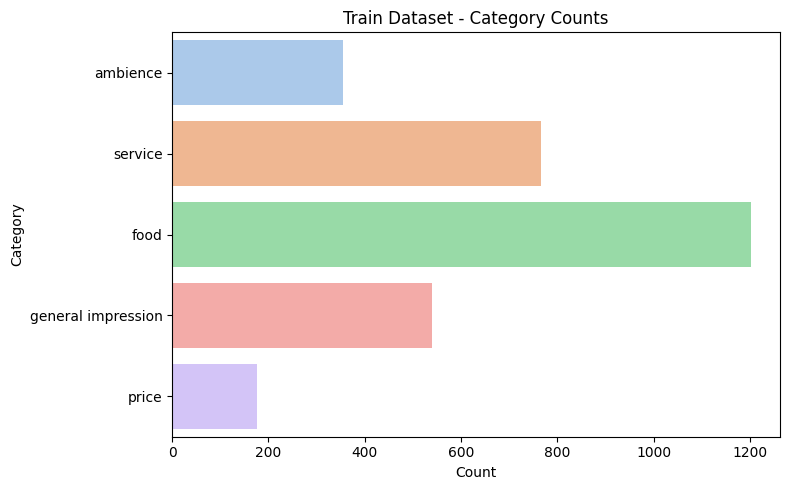

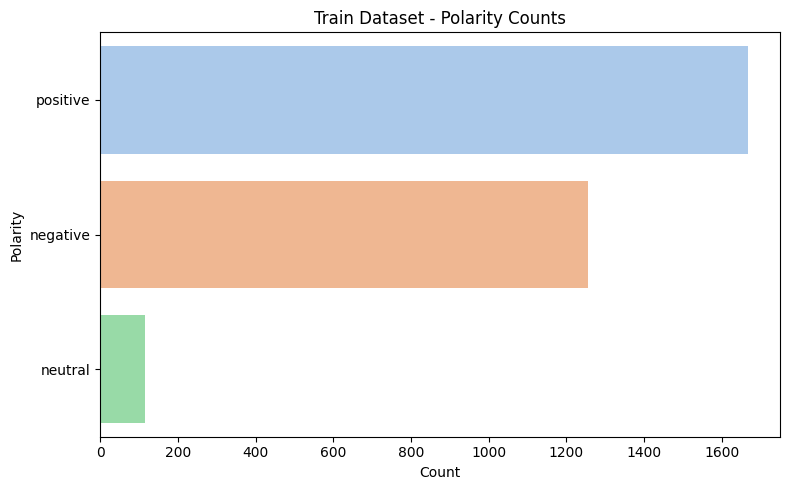

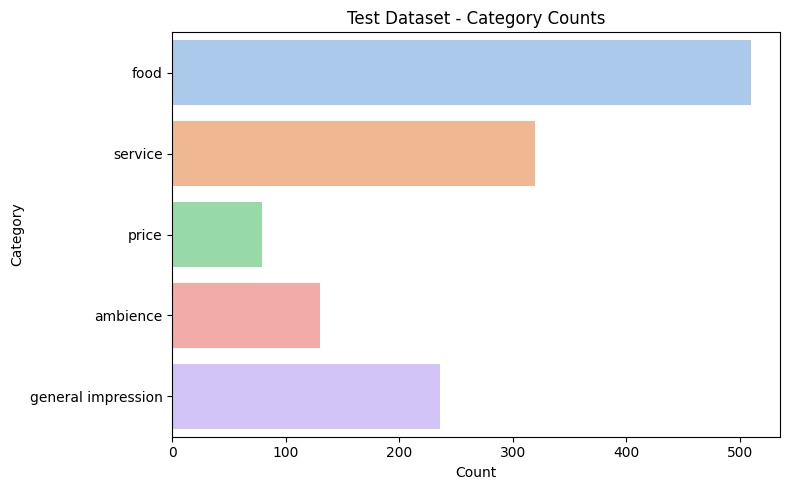

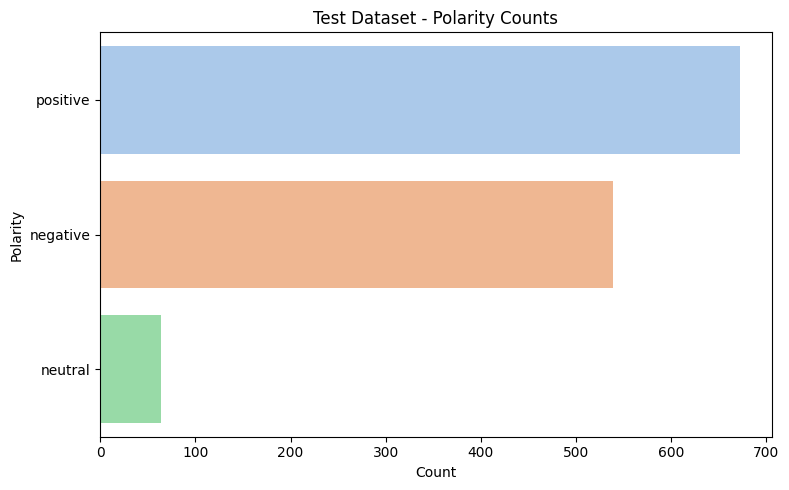

In [4]:
# Plot 1: Train Categories
train_cat_df = counter_to_df(results['train']['categories'], 'Category')
plot_counts(train_cat_df, 'Train Dataset - Category Counts', 'Category')

# Plot 2: Train Polarities
train_pol_df = counter_to_df(results['train']['polarities'], 'Polarity')
plot_counts(train_pol_df, 'Train Dataset - Polarity Counts', 'Polarity')

# Plot 3: Test Categories
test_cat_df = counter_to_df(results['test']['categories'], 'Category')
plot_counts(test_cat_df, 'Test Dataset - Category Counts', 'Category')

# Plot 4: Test Polarities
test_pol_df = counter_to_df(results['test']['polarities'], 'Polarity')
plot_counts(test_pol_df, 'Test Dataset - Polarity Counts', 'Polarity')

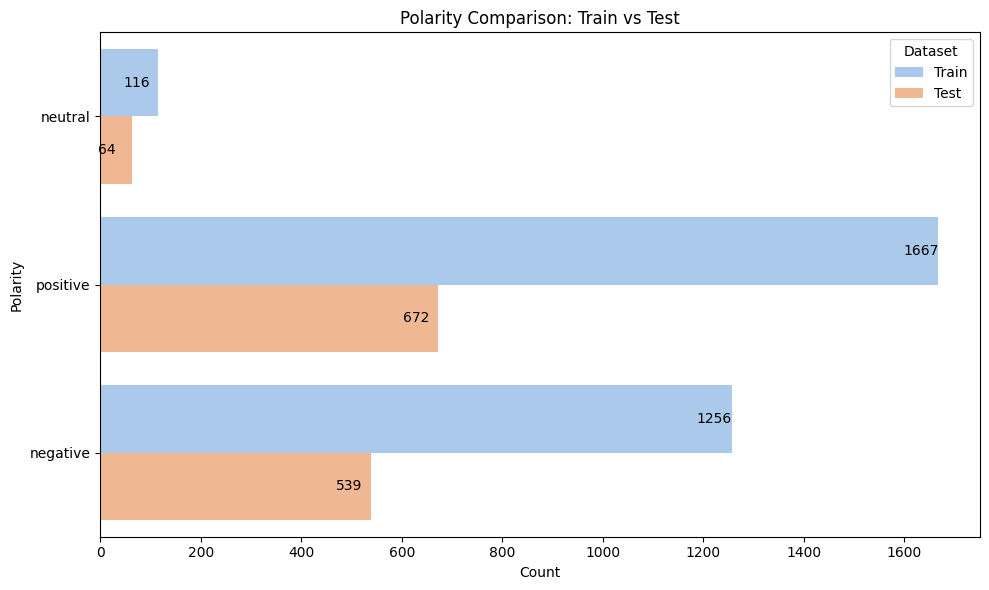

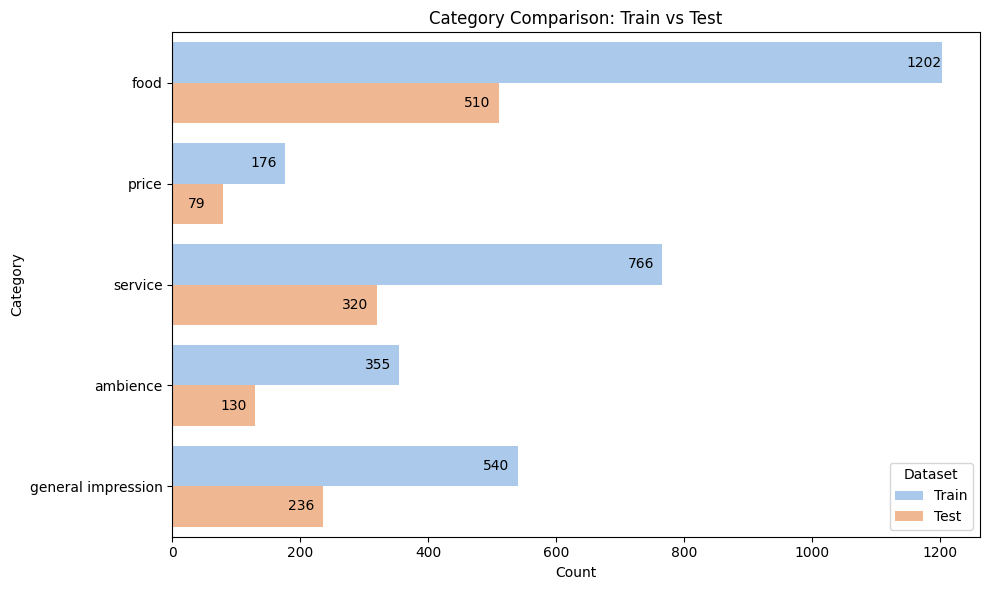

In [5]:
polarity_comp_df = prepare_comparison_df(
    results['train']['polarities'], results['test']['polarities'], label_name='Polarity'
)
category_comp_df = prepare_comparison_df(
    results['train']['categories'], results['test']['categories'], label_name='Category'
)
# Plot comparisons
plot_comparison(polarity_comp_df, label_col='Polarity', title='Polarity Comparison: Train vs Test')
plot_comparison(category_comp_df, label_col='Category', title='Category Comparison: Train vs Test')

In [7]:
for split in ['train', 'test']:
    length_info = results[split]['length_info']

    print(f"{split.capitalize()} dataset:")
    print(f"Average length: {length_info['average_length']:.2f}")
    print(f"Median length: {length_info['median_length']:.2f}\n")

    longest = length_info['longest_text']
    print(f"Longest {split} text (ID: {longest.get('id', 'N/A')}):")
    print(f"Length: {len(longest['text'])}")
    print(longest['text'])
    print()

    shortest = length_info['shortest_text']
    print(f"Shortest {split} text (ID: {shortest.get('id', 'N/A')}):")
    print(f"Length: {len(shortest['text'])}")
    print(shortest['text'])
    print("\n" + "="*50 + "\n")

Train dataset:
Average length: 73.85
Median length: 61.00

Longest train text (ID: 974):
Length: 410
Das Schnitzel war das Fleisch gut jedoch weder Fleisch noch Panade gesalzen und Gewürzt nach würzen bringt es nicht die Bratkartoffeln auch beim Tagesgericht verdienen das Wort nicht nur wenige waren gebraten alle anderen offensichtlich in noch nich erhitzten Fett oder Öl warm gemacht dadurch haben sie sich vollgesogen so was darf man nicht servieren den Kellnern den wir das dagegen interessieren sich nicht

Shortest train text (ID: 1435):
Length: 6
Schade


Test dataset:
Average length: 72.04
Median length: 62.00

Longest test text (ID: 495):
Length: 348
Auf die Heißgetränke haben wir fast 20 Minuten gewartet, trotz 2 maligen nachfragen, dann hieß es, als sie endlich kamen, die Maschine hätte einen Stromausfall gehabt ( für den Tisch gegenüber hat sie anscheinend funktioniert) bei Begleichung der Rechnung wurde dann noch extra nachgefragt, ob wir noch Trinkgeld für Service /Küche geben